In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from IPython import display
import matplotlib.pyplot as plt

In [2]:
class dqn_agent():
    def __init__(self):     
        
        self.num_actions = 2
        self.model = self.create_q_model()
        self.model_target = self.create_q_model()
        self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
        self.loss_function = keras.losses.Huber()
        self.gamma = 0.99
        
        self.batch_size = 512
        self.memory = self.ReplayMemory(100000)
        
        self.step = 0
        self.update_step_interval = 4
        self.init_random_steps = 10000
        self.update_target_network = 10000
        
        self.epsilon = 1.0
        self.epsilon_min = 0.05  
        epsilon_greedy_steps = 250000.0
        self.epsilon_decay_step = (self.epsilon - self.epsilon_min) / epsilon_greedy_steps
        
    class ReplayMemory(object):

        def __init__(self, capacity):
            self.idx = 0
            self.capacity = capacity
            self.is_full = False
            self.memory = {'state':np.zeros((capacity, 80,80,1), dtype=np.float32),
                           'Action':np.zeros((capacity), dtype=int),
                           'reward':np.zeros((capacity), dtype=np.float32),
                           'next_state':np.zeros((capacity, 80,80,1), dtype=np.float32),
                           'done':np.zeros((capacity), dtype=bool)}
    
        def push_episode(self, args):
            for ind, k in enumerate(self.memory.keys()):
                i,j = self.idx, min(self.capacity, self.idx+len(args[ind]))
                self.memory[k][i:j] = args[ind][:j-i]

            self.idx +=  len(args[0])
            if self.idx >= self.capacity:
                self.idx=0
                self.is_full = True

        def sample(self, batch_size):
            sample_idx = np.random.choice(self.__len__(), batch_size, replace=False) 
            return [self.memory[k][sample_idx] for k in self.memory.keys()]           

        def __len__(self):
            return self.capacity if self.is_full else self.idx
    
    
    def create_q_model(self):
        inputs = layers.Input(shape=(80, 80, 1,))
        x = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
        x = layers.Conv2D(32, 4, strides=2, activation="relu")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(256, activation="relu")(x)
        action = layers.Dense(self.num_actions, activation="linear")(x)
        return keras.Model(inputs=inputs, outputs=action)
    
    def select_action(self, state):
        self.step+=1
        self.epsilon -= self.epsilon_decay_step
        self.epsilon = max(self.epsilon, self.epsilon_min)
        
        if self.epsilon > np.random.rand(1)[0]:
            action = np.random.choice(self.num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = self.model(state_tensor, training=False)
            action = tf.argmax(action_probs[0]).numpy()
        return action
    
    def push_episode(self, args):
        self.memory.push_episode(args)
    
    def train_step(self):
        if self.step % self.update_step_interval == 0 and self.step > self.init_random_steps:
            state, action, reward, next_state, done = self.memory.sample(self.batch_size)
            future_actions = tf.argmax(self.model.predict(np.array(next_state)), axis=1) 
            future_rewards = self.model_target.predict(np.array(next_state))[:,future_actions]
            future_rewards*= (1 - np.array(done)) 
            target_q_values = np.array(reward) + self.gamma * future_rewards

            masks = tf.one_hot(np.array(action), self.num_actions)
            with tf.GradientTape() as tape:
                q_values = tf.reduce_sum(tf.multiply(self.model(np.array(state)), masks), axis=1)
                loss = self.loss_function(q_values, target_q_values)
            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            
        if self.step % self.update_target_network == 0:
            self.model_target.set_weights(self.model.get_weights())
            #self.model.save("dqn_checkpoints/step_"+str(self.step))

In [3]:
def discounted_rewards(rewards, discount_rate = 0.98):
    for i in reversed(range(len(rewards))):
        if rewards[i] == 0: 
            rewards[i] += discount_rate* rewards[i+1]
    return np.asarray(rewards)

#From Andrej Pong from Pixels blog: http://karpathy.github.io/2016/05/31/rl/
def prepro(I):
    I = I[35:195:2,::2, 0] # crop and downsample by factor of 2
    I[(I == 144) | (I == 109)] = 0 # erase background
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float32)

env = gym.make("PongDeterministic-v4")
agent = dqn_agent()
running_rewards = [-21]
skip_frames = 2

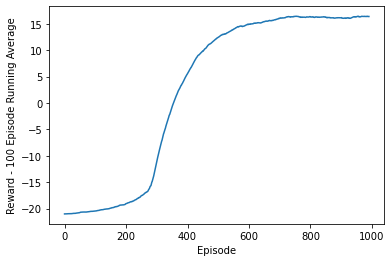

running reward: 16.37 episode_reward 17.0 epsilon 0.05
!!!!!!!!!!


In [ ]:
while True:
    done = False
    reward_stat = 0
    screen = prepro(env.reset())
    state = np.dstack([screen, screen])
    next_state = state
    eps_state, eps_action, eps_next_state, eps_reward, eps_done = [],[],[],[],[]
    while not done:
        env.render()
        state = np.expand_dims(state[:,:,1] - state[:,:,0], axis=2)
        action = agent.select_action(state)
        reward = 0
        for _ in range(skip_frames):
            if done: break
            screen, r, done, _ = env.step(action+2)
            reward+=r
  
        next_state[:,:,0] = next_state[:,:,1]
        next_state[:,:,1] = prepro(screen)
        eps_state.append(state), eps_action.append(action) 
        eps_next_state.append(np.expand_dims(next_state[:,:,1] - next_state[:,:,0], axis=2))
        eps_reward.append(reward), eps_done.append(done)
        state = next_state
        agent.train_step()
        reward_stat+=reward 

    agent.push_episode([eps_state, eps_action, discounted_rewards(eps_reward), eps_next_state, eps_done])
    
    plt.clf()
    plt.xlabel('Episode')
    plt.ylabel('Reward - 100 Episode Running Average')
    running_rewards.append(0.99 * running_rewards[-1] + 0.01* reward_stat)
    plt.plot(np.array(running_rewards))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    template = "running reward: {:.2f} episode_reward {} epsilon {}"
    print(template.format(running_rewards[-1], reward_stat, agent.epsilon))
    if reward_stat > 0:
        print('!'*10)

In [ ]:
#agent.model.save("dqn_checkpoints/step_final")
#save('./experiment/DQN.npy', np.asarray(running_rewards))